[OpenAI Gym 经典控制环境介绍——CartPole（倒立摆）](https://zhuanlan.zhihu.com/p/570695189)

In [ ]:
from gym import envs
d = envs.registry
for k, v in d.items():
    print(f"{k} -> {v}")

In [ ]:
import gym
import matplotlib.pyplot as plt
from IPython import display

env = gym.make('CartPole-v1', render_mode='rgb_array')      
obs, _ = env.reset()

# 初始化图像对象
frame = env.render()
plt.ion()  # 打开交互模式
fig, ax = plt.subplots()
img = ax.imshow(frame)
display.display(plt.gcf())

for _ in range(500):
    frame = env.render()
    img.set_data(frame)  # 只更新图像数据，而不是重建
    display.clear_output(wait=True)
    display.display(plt.gcf())
    # plt.pause(0.001)  # 小延时允许刷新
    action = env.action_space.sample()
    print(f"Action taken: {action} {env.observation_space}")
    obs, _, terminated, truncated, _ = env.step(action)
    
    # if terminated or truncated:
        # print(f"{terminated} {truncated}")
        # obs, _ = env.reset()

plt.ioff()
env.close()


In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np

# 定义策略网络
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# 定义价值网络
class ValueNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# PPO 代理
class PPOAgent:
    def __init__(self, input_dim, hidden_dim, output_dim, lr_policy=3e-4, lr_value=1e-3, gamma=0.99, lambd=0.95, epsilon=0.2):
        self.policy = PolicyNetwork(input_dim, hidden_dim, output_dim)
        self.value = ValueNetwork(input_dim, hidden_dim)
    
        self.optimizer_policy = optim.Adam(self.policy.parameters(), lr=lr_policy)
        self.optimizer_value = optim.Adam(self.value.parameters(), lr=lr_value)
    
        self.gamma = gamma
        self.lambd = lambd
        self.epsilon = epsilon
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.policy(state)
        dist = Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item()#, log_prob

    def compute_advantages(self, rewards, values, next_values, dones):
        advantages = torch.zeros_like(rewards)
        advantages[-1] = rewards[-1] + self.gamma * (1 - dones[-1]) * next_values[-1] - values[-1]
    
        for t in reversed(range(len(rewards)-1)):
            delta = rewards[t] + self.gamma * (1 - dones[t]) * next_values[t] - values[t]
            advantages[t] = delta + self.gamma * self.lambd * (1 - dones[t]) * advantages[t+1]
    
        returns = advantages + values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    
        return returns, advantages

    def update(self, states, actions, log_probs_old, returns, advantages):
        states = torch.tensor(states, dtype=torch.float)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(-1)
        log_probs_old = torch.stack(log_probs_old).detach()
        returns = torch.tensor(returns, dtype=torch.float).unsqueeze(-1)
        advantages = torch.tensor(advantages, dtype=torch.float).unsqueeze(-1)
    
        for _ in range(10):  # 更新纪元数
            log_probs = self.policy(states).gather(1, actions)
            ratio = (log_probs / log_probs_old).exp()
        
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantages
        
            loss_policy = -torch.min(surr1, surr2).mean()
        
            self.optimizer_policy.zero_grad()
            loss_policy.backward()
            self.optimizer_policy.step()
        
            values = self.value(states)
            loss_value = nn.MSELoss()(values, returns)
        
            self.optimizer_value.zero_grad()
            loss_value.backward()
            self.optimizer_value.step()

def train_ppo(env, agent, max_timesteps=500, batch_size=5000, n_updates=10):
    state, _ = env.reset()  # 处理Gym v0.26+的返回值
    episode_rewards = []
    all_rewards = []
    t = 0

    while t < max_timesteps:
        states, actions, rewards, next_states, dones, log_probs = [], [], [], [], [], []
        batch_rewards = 0
    
        # 收集轨迹
        for _ in range(batch_size):
            action, log_prob = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)  # Gym v0.26+的返回参数
            done = terminated or truncated  # 合并终止标志
        
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            log_probs.append(log_prob)
        
            if done:
                state, _ = env.reset()  # 重置环境并获取初始状态
            else:
                state = next_state
            batch_rewards += reward
            t += 1
        
            if done or t >= max_timesteps:
                break
    
        episode_rewards.append(batch_rewards)
        all_rewards.extend(rewards)
    
        # 计算回报和优势
        states_tensor = torch.tensor(np.array(states), dtype=torch.float)
        next_states_tensor = torch.tensor(np.array(next_states), dtype=torch.float)
        dones_tensor = torch.tensor(dones, dtype=torch.float).unsqueeze(-1)
    
        with torch.no_grad():
            values = agent.value(states_tensor).squeeze()
            next_values = agent.value(next_states_tensor).squeeze()
    
        returns, advantages = agent.compute_advantages(torch.tensor(rewards, dtype=torch.float), 
                                                       values, next_values, dones_tensor.squeeze())
    
        # 更新策略和价值网络
        agent.update(states, actions, log_probs, returns.numpy(), advantages.numpy())
    
        if t >= max_timesteps:
            break

    return all_rewards, episode_rewards

# 初始化环境
env = gym.make('CartPole-v1')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
hidden_dim = 16

# 初始化PPO代理
agent = PPOAgent(input_dim, hidden_dim, output_dim)

# 训练代理
max_timesteps = 10000
batch_size = 512
all_rewards, episode_rewards = train_ppo(env, agent, max_timesteps, batch_size)

# 打印每集的平均奖励
print("每集的平均奖励:", np.mean(episode_rewards))

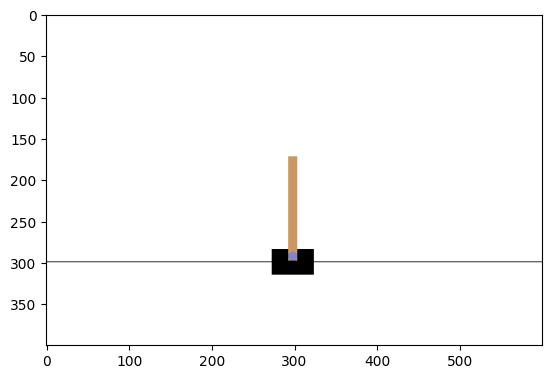

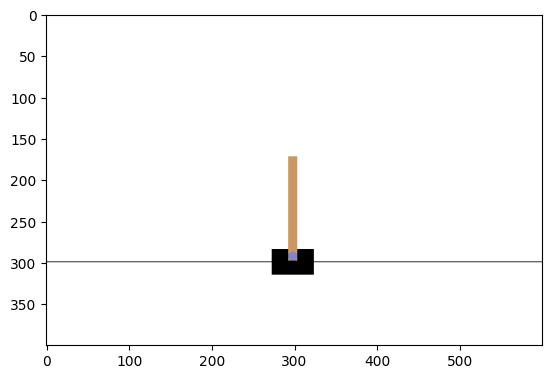

In [22]:
import matplotlib.pyplot as plt
from IPython import display
env = gym.make('CartPole-v1', render_mode='rgb_array')    
state, _ = env.reset()  # 处理Gym v0.26+的返回值
frame = env.render()
plt.ion()  # 打开交互模式
fig, ax = plt.subplots()
img = ax.imshow(frame)
display.display(plt.gcf())

for _ in range(512):
    try:
        frame = env.render()
    except Exception as e:
        print(f"渲染错误: {e}")
        break
    img.set_data(frame)  # 只更新图像数据，而不是重建
    display.clear_output(wait=True)
    display.display(plt.gcf())
    action = agent.get_action(state)
    # if state[2] < 0:
    #     action = 0
    # else:
    #     action = 1
    next_state, reward, terminated, truncated, _ = env.step(action)  # Gym v0.26+的返回参数
    state = next_state
    if  truncated:
        state, _ = env.reset()  # 重置环境并获取初始状态
plt.ioff()
env.close()

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

class DQN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, input_dim, hidden_dim, output_dim, lr=1e-3, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.q_net = DQN(input_dim, hidden_dim, output_dim)
        self.target_net = DQN(input_dim, hidden_dim, output_dim)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.memory = deque(maxlen=2000)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.output_dim = output_dim

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.output_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_net(state)
        return q_values.argmax().item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def update(self, batch_size=64):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        q_values = self.q_net(states).gather(1, actions)
        next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
        target = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_net.load_state_dict(self.q_net.state_dict())
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
            
# ...existing code...
env = gym.make('CartPole-v1')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
hidden_dim = 64
agent = DQNAgent(input_dim, hidden_dim, output_dim)

episodes = 200
batch_size = 64
for ep in range(episodes):
    state, _ = env.reset()
    total_reward = 0
    for t in range(500):
        action = agent.get_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        agent.remember(state, action, reward, next_state, done)
        agent.update(batch_size)
        state = next_state
        total_reward += reward
        if done:
            break
    agent.update_target()
    print(f"Episode {ep}, Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")
# ...existing code...

Episode 0, Reward: 14.0, Epsilon: 0.99
Episode 1, Reward: 23.0, Epsilon: 0.99
Episode 2, Reward: 53.0, Epsilon: 0.99
Episode 3, Reward: 19.0, Epsilon: 0.98
Episode 4, Reward: 40.0, Epsilon: 0.98
Episode 5, Reward: 38.0, Epsilon: 0.97
Episode 6, Reward: 20.0, Epsilon: 0.97
Episode 7, Reward: 15.0, Epsilon: 0.96
Episode 8, Reward: 15.0, Epsilon: 0.96
Episode 9, Reward: 34.0, Epsilon: 0.95
Episode 10, Reward: 15.0, Epsilon: 0.95
Episode 11, Reward: 36.0, Epsilon: 0.94
Episode 12, Reward: 15.0, Epsilon: 0.94
Episode 13, Reward: 17.0, Epsilon: 0.93
Episode 14, Reward: 19.0, Epsilon: 0.93
Episode 15, Reward: 49.0, Epsilon: 0.92
Episode 16, Reward: 33.0, Epsilon: 0.92
Episode 17, Reward: 18.0, Epsilon: 0.91
Episode 18, Reward: 31.0, Epsilon: 0.91
Episode 19, Reward: 12.0, Epsilon: 0.90
Episode 20, Reward: 16.0, Epsilon: 0.90
Episode 21, Reward: 17.0, Epsilon: 0.90
Episode 22, Reward: 10.0, Epsilon: 0.89
Episode 23, Reward: 14.0, Epsilon: 0.89
Episode 24, Reward: 12.0, Epsilon: 0.88
Episode 25